# Integration of DataProfiler with Synthetic Data Generator

We want to use the DataProfiler to quantify all the characteristics of the real dataset. Then we use this information as parameters for Syntthetic Data to make a synthetic dataset that mimics the real dataset. Only dealing with numeric datasets for now.

The steps are:
1. Generate a profile report with the Real Dataset
   - enable the correlation matrix and disable any unnecessary calcs
2. Map the report into `synthetic_data.make_data_from_report` to generate the Synthetic Dataset
    - we now have a private dataset that mimics the real one
    - we can also tweak parameters or even add post processing
  
![Workflow Diagram!](https://i.imgur.com/FYW80xO_d.webp?maxwidth=760&fidelity=grand)

In [1]:
import dataprofiler as dp
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from synthetic_data.synthetic_data import make_data_from_report

## Generate DataProfiler Report

In [2]:
data_path = "data/iris.csv"

In [3]:
data = dp.Data(data_path)
data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We must enable the correlation matrix. Also disabling the data labeler to avoid a performance hit.

In [4]:
profile_options = dp.ProfilerOptions()
profile_options.set({
    "data_labeler.is_enabled": False,
    "correlation.is_enabled": True,
})

profile = dp.Profiler(data, options=profile_options)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 5 processes)


  0%|          | 0/5 [00:00<?, ?it/s]/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will 

INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


In [5]:
report = profile.report()
report

{'global_stats': {'samples_used': 150,
  'column_count': 5,
  'row_count': 150,
  'row_has_null_ratio': 0.0,
  'row_is_null_ratio': 0.0,
  'unique_row_ratio': 0.98,
  'duplicate_row_count': 3,
  'file_type': 'csv',
  'encoding': 'utf-8',
  'correlation_matrix': array([[ 1.        , -0.10936925,  0.87175416,  0.81795363,  0.78256123],
         [-0.10936925,  1.        , -0.4205161 , -0.35654409, -0.4194462 ],
         [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ,  0.94904254],
         [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ,  0.95646382],
         [ 0.78256123, -0.4194462 ,  0.94904254,  0.95646382,  1.        ]]),
  'chi2_matrix': array([[nan, nan, nan, nan, nan],
         [nan,  1., nan,  0.,  0.],
         [nan, nan, nan, nan, nan],
         [nan,  0., nan,  1.,  0.],
         [nan,  0., nan,  0.,  1.]]),
  'profile_schema': defaultdict(list,
              {'SepalLengthCm': [0],
               'SepalWidthCm': [1],
               'PetalLengthCm': [2],
             

In [6]:
x = make_data_from_report(report=report, seed=111)

In [7]:
x

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,7.3,2.4,6.8,1.9,2.0
1,6.6,3.1,5.4,1.7,1.0
2,5.7,3.8,2.8,1.4,1.0
3,5.8,2.9,4.7,1.2,1.0
4,6.3,3.4,5.4,1.6,1.0
...,...,...,...,...,...
145,6.1,3.2,2.7,1.0,1.0
146,4.7,3.5,1.2,0.5,0.0
147,7.6,2.6,6.8,2.1,2.0
148,6.2,3.8,2.3,1.1,1.0


<AxesSubplot:>

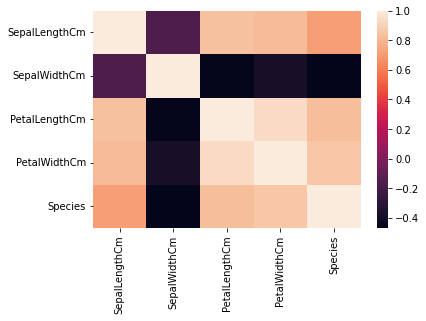

In [8]:
sns.heatmap(x.corr())

<AxesSubplot:>

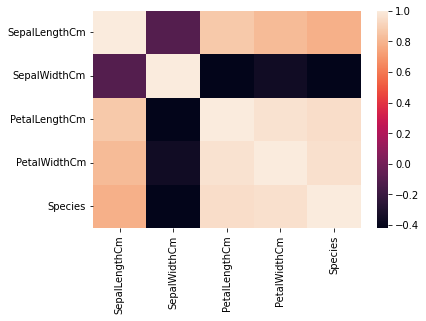

In [9]:
sns.heatmap(pd.read_csv(data_path).corr())

In [10]:
iris = datasets.load_iris()

training_data, test_data = train_test_split(iris.data, test_size=0.2, random_state=111)
training_target, test_target = train_test_split(iris.target, test_size=0.2, random_state=111)

clf = SVC()

clf.fit(training_data, training_target)

SVC()

In [11]:
test_results = clf.predict(test_data)
model_accuracy = list(test_results == test_target).count(True) / len(test_target)

print(f"The model was {round(model_accuracy * 100, 2)}% accurate on the authentic data")

The model was 86.67% accurate on the authentic data


In [12]:
synthetic_data = x.to_numpy()[:,:-1]
synthetic_target = x.to_numpy()[:,-1:].flatten()

synthetic_results = clf.predict(synthetic_data)
synthetic_accuracy = list(synthetic_results == synthetic_target).count(True) / len(synthetic_target)

print(f"The model was {round(synthetic_accuracy * 100, 2)}% accurate on the synthetic data")

The model was 67.33% accurate on the synthetic data


There's more work to be done with categorical variables, rounding, etc. but this is a start. Trying again below with a version of the dataset where I used one hot encoding instead.

In [13]:
data_path = "data/iris_one_hot.csv"

In [14]:
data = dp.Data(data_path)
data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Setosa,Versicolor,Virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,0,1
146,6.3,2.5,5.0,1.9,0,0,1
147,6.5,3.0,5.2,2.0,0,0,1
148,6.2,3.4,5.4,2.3,0,0,1


We must enable the correlation matrix. Also disabling the data labeler to avoid a performance hit.

In [15]:
profile_options = dp.ProfilerOptions()
profile_options.set({
    "data_labeler.is_enabled": False,
    "correlation.is_enabled": True,
})

profile = dp.Profiler(data, options=profile_options)

report = profile.report()

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 7 processes)


  0%|          | 0/7 [00:00<?, ?it/s]/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/opt/miniconda3/envs/pipeline/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:514: FutureWarning: Passing a set as an indexer is deprecated and will 

INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


In [16]:
x = make_data_from_report(report=report, seed=111)

In [17]:
x

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Setosa,Versicolor,Virginica
0,7.6,3.2,6.7,2.0,0.0,1.0,1.0
1,6.2,2.9,5.3,1.7,0.0,0.0,1.0
2,7.3,3.1,6.7,1.8,0.0,1.0,1.0
3,6.4,3.4,4.3,1.3,1.0,0.0,1.0
4,6.5,2.7,5.2,1.5,0.0,1.0,0.0
...,...,...,...,...,...,...,...
145,5.3,3.5,1.1,0.4,1.0,1.0,0.0
146,5.8,2.7,3.1,1.0,0.0,1.0,0.0
147,4.7,3.4,1.0,0.3,1.0,0.0,0.0
148,5.4,3.1,4.6,1.6,0.0,0.0,1.0


<AxesSubplot:>

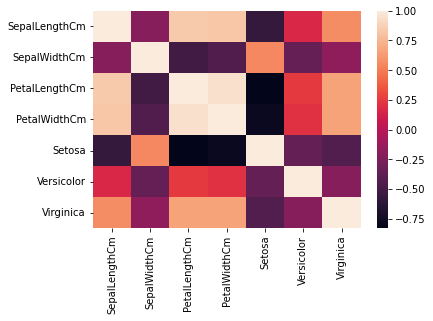

In [18]:
sns.heatmap(x.corr())

<AxesSubplot:>

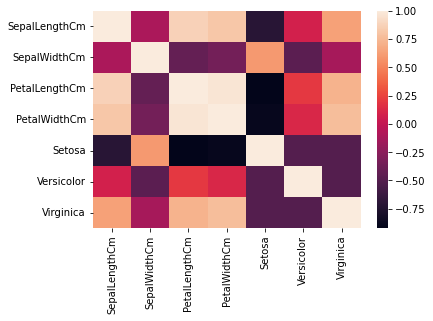

In [19]:
sns.heatmap(pd.read_csv(data_path).corr())